<a href="https://colab.research.google.com/github/yuvalira/SER-Sinc-Speech-Emotion-Recognition-via-Multi-scale-Sinc-Filters-/blob/main/data_loading/Data_Preparation_and_Augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Data Preparation and Augmentation**

In this notebook, we load the RAVDESS dataset, standardize the raw audio inputs, and apply preprocessing steps required for model training. These steps include resampling, mono conversion, padding/clipping to fixed length, normalization, and basic data augmentation techniques such as noise injection and time shifting. The processed data will be used in downstream notebooks for model training and evaluation.


## 1. Setup and Imports
Import required libraries for audio processing, file handling, and dataset management.

In [1]:
import os
import glob
import torch
import torchaudio
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import random
import torchaudio.transforms as T
from tqdm import tqdm

## 2. Dataset Download and Extraction
Use the Kaggle API to download and extract the RAVDESS dataset.

In [2]:
# Upload kaggle.json API token
from google.colab import files
files.upload()  # Select your kaggle.json file here

# Move kaggle.json to the correct location and set permissions
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download the RAVDESS dataset from Kaggle
!kaggle datasets download -d uwrfkaggler/ravdess-emotional-speech-audio

# Force unzip even if files already exist (overwrite silently)
!unzip -o -q ravdess-emotional-speech-audio.zip -d ravdess_data

# List the contents to confirm
!ls ravdess_data

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/uwrfkaggler/ravdess-emotional-speech-audio
License(s): CC-BY-NC-SA-4.0
 90% 385M/429M [00:00<00:00, 1.34GB/s]
100% 429M/429M [00:00<00:00, 1.34GB/s]
Actor_01  Actor_06  Actor_11  Actor_16	Actor_21
Actor_02  Actor_07  Actor_12  Actor_17	Actor_22
Actor_03  Actor_08  Actor_13  Actor_18	Actor_23
Actor_04  Actor_09  Actor_14  Actor_19	Actor_24
Actor_05  Actor_10  Actor_15  Actor_20	audio_speech_actors_01-24


## 3. Custom Dataset Class: RAVDESSDataset
Define a PyTorch `RAVDESSDataset` class that loads and preprocesses audio: resampling, trimming, mono conversion, and normalization.

In [3]:
class RAVDESSDataset(Dataset):
    def __init__(self, root_dir, sample_rate=16000, duration=3, augment=False):
        self.root_dir = root_dir
        self.sample_rate = sample_rate
        self.fixed_length = sample_rate * duration
        self.augment = augment
        self.augmenter = AudioAugment() if augment else None

        self.file_paths = glob.glob(os.path.join(root_dir, '**', '*.wav'), recursive=True)

        self.label_map = {
            '01': 0,  # neutral
            '02': 1,  # calm
            '03': 2,  # happy
            '04': 3,  # sad
            '05': 4,  # angry
            '06': 5,  # fearful
            '07': 6,  # disgust
            '08': 7   # surprised
        }

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        file_path = self.file_paths[idx]

        # Load and preprocess waveform
        waveform, sr = torchaudio.load(file_path)

        # Convert stereo to mono
        if waveform.shape[0] > 1:
            waveform = torch.mean(waveform, dim=0, keepdim=True)

        # Resample if needed
        if sr != self.sample_rate:
            resampler = torchaudio.transforms.Resample(orig_freq=sr, new_freq=self.sample_rate)
            waveform = resampler(waveform)

        # Fix length
        if waveform.shape[1] > self.fixed_length:
            waveform = waveform[:, :self.fixed_length]
        elif waveform.shape[1] < self.fixed_length:
            padding = self.fixed_length - waveform.shape[1]
            waveform = torch.nn.functional.pad(waveform, (0, padding))

        # Augment if enabled
        if self.augmenter:
            waveform = self.augmenter(waveform)

        # Label from filename
        filename = os.path.basename(file_path)
        emotion_code = filename.split("-")[2]
        label = self.label_map[emotion_code]

        return waveform, label

## 4. Dataset Inspection and Waveform Visualization
Create a dataset instance, inspect a sample, and visualize its waveform and label.

In [4]:
# Set dataset root path
dataset_path = "ravdess_data/"  # this is where the files were unzipped

# Create dataset instance
full_dataset = RAVDESSDataset(root_dir=dataset_path)

Label index: 6
Waveform shape: torch.Size([1, 48000])


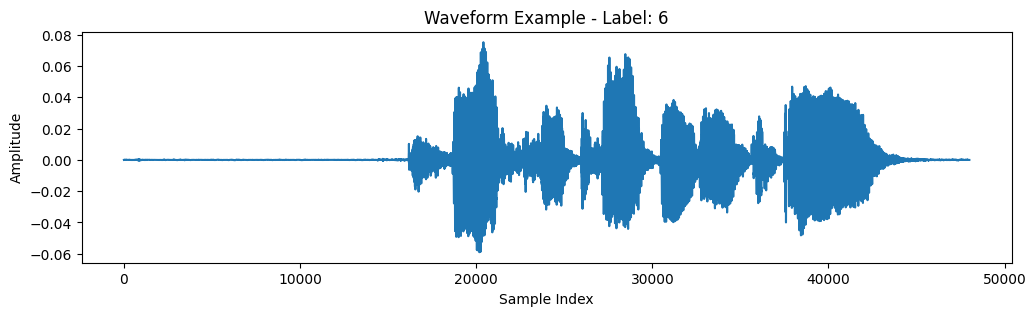

In [5]:
# Visualize one sample from the dataset
waveform, label = full_dataset[0]

print(f"Label index: {label}")
print(f"Waveform shape: {waveform.shape}")  # should be (48000,)

# Plot the waveform
plt.figure(figsize=(12, 3))
plt.plot(waveform.squeeze(0).numpy())
plt.title(f"Waveform Example - Label: {label}")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.show()

## 4. Dataset Splitting
Split the dataset into training, validation, and test sets, using either `random_split`.

In [6]:
# Total dataset size
total_size = len(full_dataset)

# Split ratios
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

# Compute lengths
train_size = int(train_ratio * total_size)
val_size = int(val_ratio * total_size)
test_size = total_size - train_size - val_size  # to handle rounding

# Split the dataset
train_dataset, val_dataset, test_dataset = random_split(
    full_dataset,
    [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)  # reproducible split
)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

print(f"Total samples: {total_size}")
print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")

Total samples: 2880
Training set size: 2304
Validation set size: 288
Test set size: 288


## 5. Train Audio Augmentation
Define and integrate audio augmentation methods (e.g., time shift, noise injection) for use during training only.

In [7]:
# Extract file paths of training set from random_split
train_indices = train_dataset.indices  # Get indices from the training Subset
train_files = [full_dataset.file_paths[i] for i in train_indices]  # Map indices to file paths

# Print summary
print(f"Number of training files: {len(train_files)}")
print(f"First training file path: {train_files[0]}")

Number of training files: 2304
First training file path: ravdess_data/audio_speech_actors_01-24/Actor_03/03-01-07-02-01-01-03.wav


In [14]:
class EmotionAwareAugment:
    def __init__(self, sample_rate=16000, apply_prob=0.8):
        self.sample_rate = sample_rate
        self.apply_prob = apply_prob

    def __call__(self, waveform, label):
        # Label: integer 0-7 representing the emotion class
        if random.random() > self.apply_prob:
            return waveform  # no augmentation this time

        if label == 2:  # happy
            waveform = self.pitch_shift(waveform, steps=1)
            waveform = self.volume_change(waveform, factor=1.1)
        elif label == 3:  # sad
            waveform = self.pitch_shift(waveform, steps=-1)
            waveform = self.time_stretch(waveform, factor=0.95)
        elif label == 4:  # angry
            waveform = self.volume_change(waveform, factor=1.2)
            waveform = self.add_noise(waveform, noise_std=0.01)
        elif label == 1 or label == 0:  # calm / neutral
            waveform = self.time_shift(waveform, max_shift=1000)
        elif label == 5:  # fearful
            waveform = self.pitch_shift(waveform, steps=1)
            waveform = self.add_noise(waveform)
        elif label == 6:  # disgust
            waveform = self.volume_change(waveform, factor=1.1)
        elif label == 7:  # surprised
            waveform = self.pitch_shift(waveform, steps=2)
            waveform = self.volume_change(waveform, factor=1.2)

        return waveform

    def pitch_shift(self, waveform, steps=1):
        transform = T.PitchShift(
            sample_rate=self.sample_rate,
            n_steps=steps
        ).to(waveform.device)  # this fixes the window device mismatch
        return transform(waveform)

    def time_stretch(self, waveform, factor=0.95):
        new_sr = int(self.sample_rate * factor)
        resample = T.Resample(orig_freq=self.sample_rate, new_freq=new_sr).to(waveform.device)
        return resample(waveform)

    def volume_change(self, waveform, factor=1.1):
        return waveform * factor

    def add_noise(self, waveform, noise_std=0.005):
        noise = torch.randn_like(waveform) * noise_std
        return waveform + noise

    def time_shift(self, waveform, max_shift=1600):
        shift = random.randint(-max_shift, max_shift)
        return torch.roll(waveform, shifts=shift, dims=-1)

In [9]:
output_dir = "/content/expanded_dataset"  # new dataset folder
os.makedirs(output_dir, exist_ok=True)    # create folder if it doesn't exist

In [15]:
# Parameters
sample_rate = 16000
fixed_length = sample_rate * 3
num_augmentations_per_sample = 3
output_dir = "/content/expanded_dataset"
os.makedirs(output_dir, exist_ok=True)

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the emotion-aware augmenter
augmenter = EmotionAwareAugment(sample_rate=sample_rate)

# Label mapping
label_map = {
    '01': 0, '02': 1, '03': 2, '04': 3,
    '05': 4, '06': 5, '07': 6, '08': 7
}

# Counter for saved files
counter = 0

for path in tqdm(train_files, desc="Expanding dataset with GPU"):
    waveform, sr = torchaudio.load(path)

    # Convert to mono
    if waveform.shape[0] > 1:
        waveform = torch.mean(waveform, dim=0, keepdim=True)

    # Move to GPU
    waveform = waveform.to(device).float()

    # Resample
    if sr != sample_rate:
        resampler = torchaudio.transforms.Resample(
            orig_freq=sr, new_freq=sample_rate).to(device)
        waveform = resampler(waveform)

    # Trim or pad
    if waveform.shape[1] > fixed_length:
        waveform = waveform[:, :fixed_length]
    elif waveform.shape[1] < fixed_length:
        padding = fixed_length - waveform.shape[1]
        waveform = F.pad(waveform, (0, padding))

    # Normalize
    waveform = waveform / waveform.abs().max()

    # Get label from filename
    filename = os.path.basename(path)
    emotion_code = filename.split("-")[2]
    label = label_map[emotion_code]

    # Save original (move to CPU before saving)
    torch.save({
        "waveform": waveform.cpu(),
        "label": label
    }, f"{output_dir}/sample_{counter}.pt")
    counter += 1

    # Save augmented versions
    for _ in range(num_augmentations_per_sample):
        aug_waveform = augmenter(waveform.clone(), label)  # stays on GPU
        torch.save({
            "waveform": aug_waveform.cpu(),
            "label": label
        }, f"{output_dir}/sample_{counter}.pt")
        counter += 1

print(f"\n Saved {counter} samples to {output_dir} using GPU acceleration.")


Expanding dataset with GPU: 100%|██████████| 2304/2304 [08:26<00:00,  4.55it/s]


 Saved 9216 samples to /content/expanded_dataset using GPU acceleration.


In [20]:
import os
from google.colab import drive

# Step 1: Mount Google Drive
drive.mount('/content/drive')

# Step 2: Zip the dataset (if not already zipped)
zip_path = "/content/expanded_dataset.zip"
if not os.path.exists(zip_path):
    !zip -r {zip_path} /content/expanded_dataset

# Step 3: Define destination path in your Google Drive
drive_destination = "/content/drive/MyDrive/expanded_dataset.zip"

# Step 4: Copy ZIP to Drive
!cp {zip_path} "{drive_destination}"
print(f"Dataset successfully copied to Google Drive at: {drive_destination}")

Mounted at /content/drive
Dataset successfully copied to Google Drive at: /content/drive/MyDrive/expanded_dataset.zip
